# PyTorch Workflow

In [2]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all toghether"
}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all toghether'}

In [3]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

# Check PyTorch version
torch.__version__

'2.5.1+cu121'

## 1. Data (preparing and loading)

Data can be almost anything in machine learning.

* Excel spreadsheet
* Images of any kind
* Videos
* Audio
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**.

In [4]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets.

Let's create a training and test set with our data.

In [6]:
# Create a train/test split
train_split = int(0.8 * len(X))
train_split

40

In [7]:
X_train, y_train, X_test, y_test = X[:train_split], y[:train_split], X[train_split:], y[train_split:]

In [8]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [9]:
# Visualize the data.

def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
  """
  Plots training data, test data and compares predictions.
  """

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  # Plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  # Show legends
  plt.legend(prop={'size': 14})

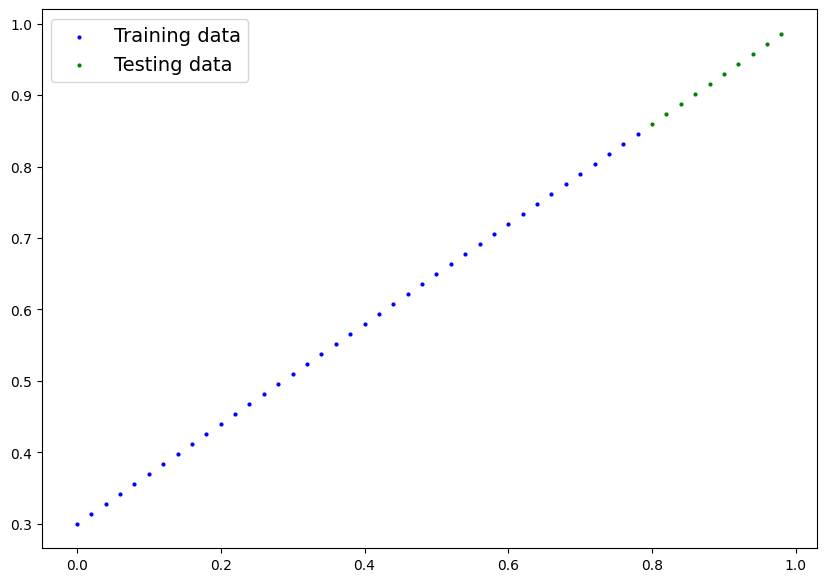

In [10]:
plot_predictions()

## 2. Build model

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the wieght & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [11]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
  # constructor
  def __init__(self):
    super().__init__()
    # Parameter 1 (weights) initialized
    self.weights = nn.Parameter(
        torch.randn(
            1,
            requires_grad=True,
            dtype=torch.float
            )
        )
    # Parameter 2 (bias) initialized
    self.bias = nn.Parameter(
        torch.randn(
            1,
            requires_grad=True,
            dtype=torch.float
            )
        )

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias # the linear regression model


### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us.
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation.

### Checking the contents of our PyTorch model

We can check our model parameters, or what's inside our model using  `.parameters()`

In [12]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predicitions using `torch.inference_mode()`

To check out our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method.

In [14]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

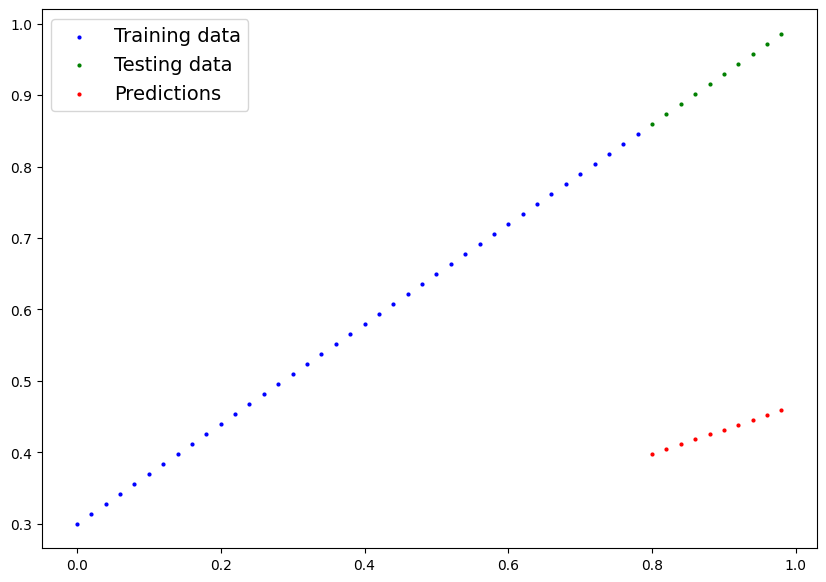

In [15]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is fro a model to move from some *unkown* parameters (these may be random) to some *known* parameters.

Or in other words, from a poor representation of the data, to a better representation of the data.

One way to measure how wrong your predictions are, is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas.

Things we neer to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.

* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function.

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [16]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [17]:
# Setup a loss function
loss_fn = nn.L1Loss() # Mean absolute error MAE

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.01 # learning rate. Possibly the most important hyperparameter, The higher the learning rate, the more it adjusts parameters
    )

### Building a training loop (and a testing loop) in PyTorch

We need:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation.
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the paramaetrs of our model with respect to the loss. (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss. (**gradient descent**)

In [18]:
# An epoch is one loop through the data... (hyperparameter we set ourselfs)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # sets all parameters thar require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  print(f"Loss: {loss}")

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop.
  # We have to zero them in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evauation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calulate the loss
    test_loss = loss_fn(test_pred, y_test)


  # Print out what's happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

  # Print out model state_dict()
  print(model_0.state_dict())

Loss: 0.31288138031959534
Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Loss: 0.3013603389263153
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
Loss: 0.28983935713768005
OrderedDict([('weights', tensor([0.3484])), ('bias', tensor([0.1588]))])
Loss: 0.2783183455467224
OrderedDict([('weights', tensor([0.3523])), ('bias', tensor([0.1688]))])
Loss: 0.26679736375808716
OrderedDict([('weights', tensor([0.3562])), ('bias', tensor([0.1788]))])
Loss: 0.2552763521671295
OrderedDict([('weights', tensor([0.3601])), ('bias', tensor([0.1888]))])
Loss: 0.24375534057617188
OrderedDict([('weights', tensor([0.3640])), ('bias', tensor([0.1988]))])
Loss: 0.23223432898521423
OrderedDict([('weights', tensor([0.3679])), ('bias', tensor([0.2088]))])
Loss: 0.22071333229541779
OrderedDict([('weights', tensor([0.3718])), ('bias', tensor([0.2188]))])
Loss: 0.20919232070446014
OrderedDict([('w

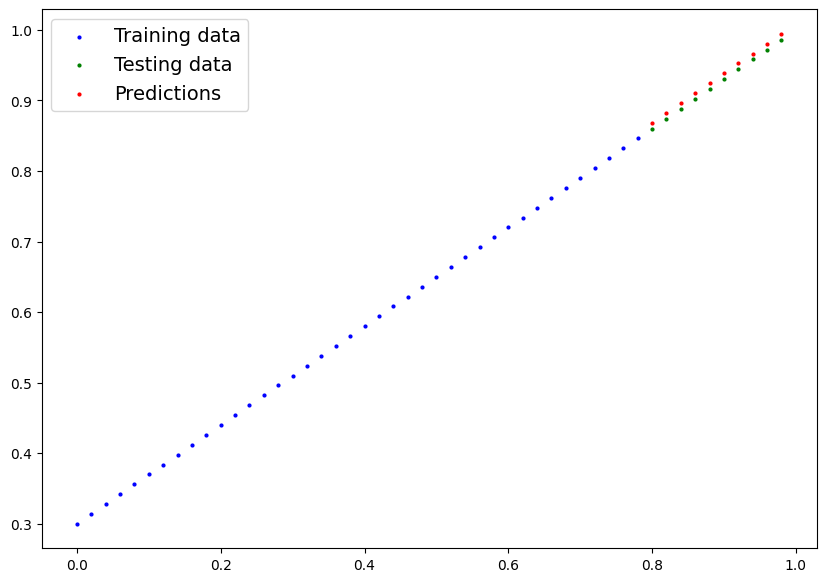

In [19]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
  plot_predictions(predictions=y_preds_new)

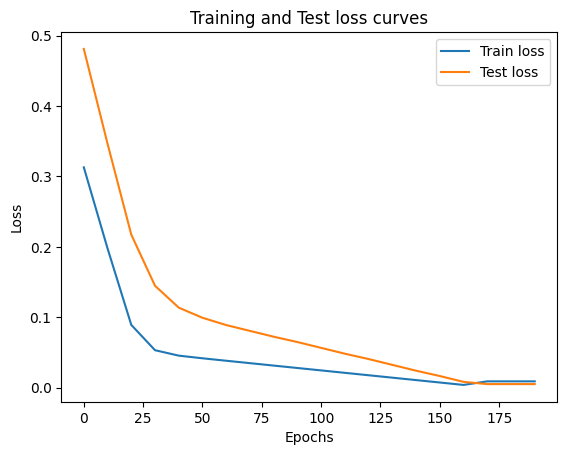

In [20]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title('Training and Test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

## Saving a model in PyTorch

There are three main methods you should know about for saving and loading models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorcj object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictrionary

In [21]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [22]:
! ls -l models

total 4
-rw-r--r-- 1 root root 1680 Dec 18 20:51 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into it.

In [23]:
# To load in a saved state_dict we have to instiantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-23-e2941c65288a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [24]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [25]:
# Make some predictions with pur loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [26]:
# Compare loaded model preds with original model preds
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back through the steps above and see it all in one piece.

In [27]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch Version
torch.__version__

'2.5.1+cu121'

Create device-agnostic code.

This means if we've got acces to GPU, our code will use ir (for potentially faster computing).

If no GPU is avaible, the code will default to using CPU.

In [28]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

In [29]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will pop up
y = weight * X + bias

# ten first numbers of X and y
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [30]:
# Split data
train_split = int(0.8 * len(X))

X_train, y_train, X_test, y_test = X[:train_split], y[:train_split], X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

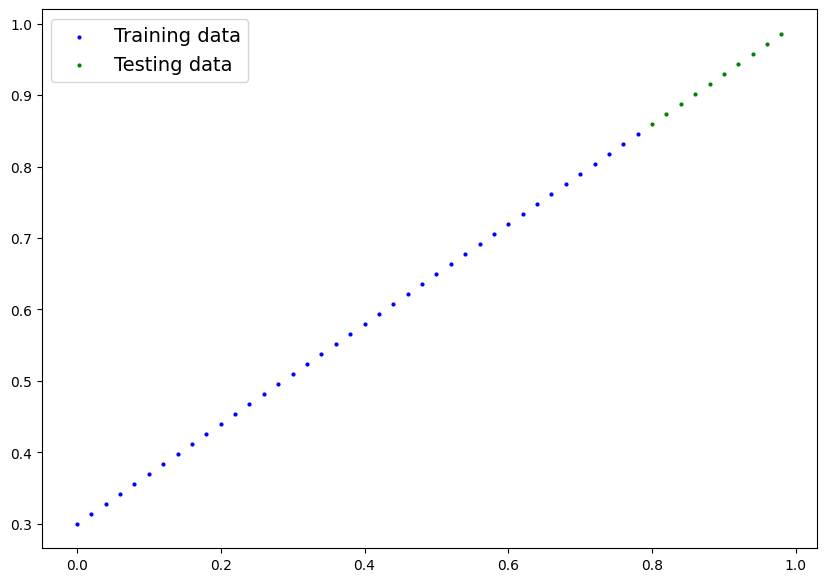

In [31]:
# Plot the data
# Note: if you don't have the plot_predictions() function loaded, this will error
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a PyTorch Linear Model

In [32]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model paameters / also called: linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor :
    return self.linear_layer(x)

In [33]:
# Set the manual seed
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [34]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [35]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [36]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.01
    )

In [37]:
# Training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer
  optimizer.step()

  ### Testing
  model_1.eval()

  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [38]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [39]:
weight, bias

(0.7, 0.3)

### 6.4 Making and evaluating predictions

In [40]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

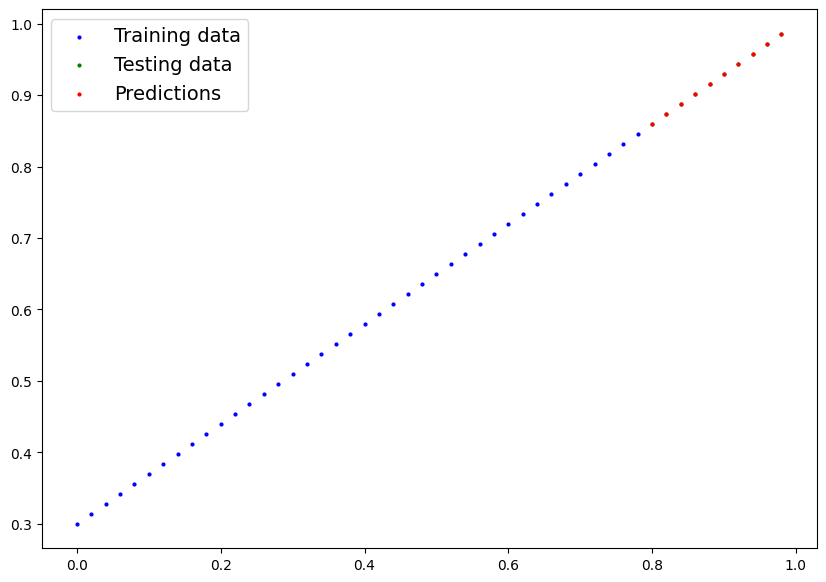

In [41]:
# Check out or model predictions viually
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving & Loading a trained model

In [43]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [44]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [46]:
# Load a PyTorch model

# Create a new instance of Linear regression model V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 stae_dict
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Put the loeaded model to device
loaded_model_1.to(device)

<ipython-input-46-99c269bcff11>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [47]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [48]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [49]:
# Evaluate loaded model
loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model_1(X_test)

In [50]:
loaded_model_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')